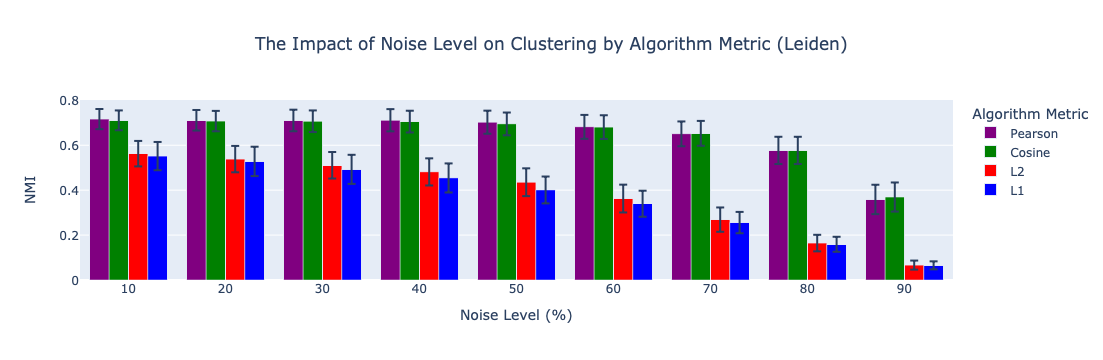

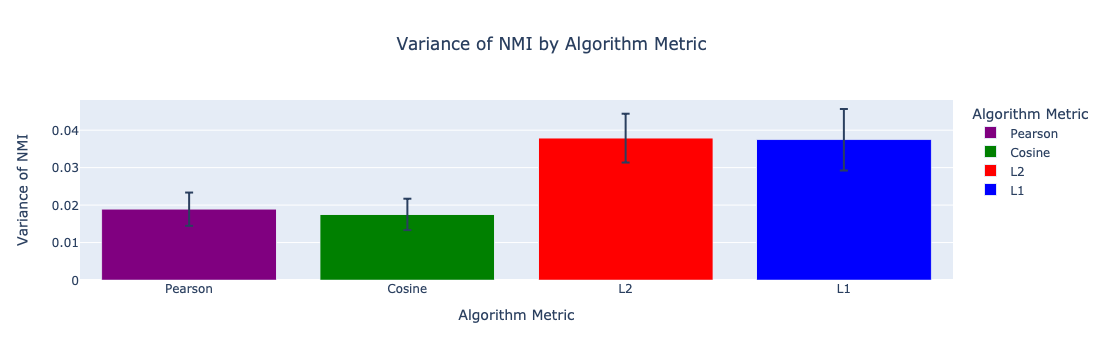

In [31]:
import pandas as pd
import plotly.express as px

# Load the results
results_df = pd.read_csv('noise_clustering_result.csv')
results_df['alg_metric'] = results_df['alg_metric'].apply(lambda x: 'L1' if x == 'l1' else x)
results_df['alg_metric'] = results_df['alg_metric'].apply(lambda x: 'L2' if x == 'l2' else x)
results_df['alg_metric'] = results_df['alg_metric'].apply(lambda x: 'Cosine' if x == 'cosine' else x)
results_df['alg_metric'] = results_df['alg_metric'].apply(lambda x: 'Pearson' if x == 'correlation' else x)

# Extract noise level from the dataset column and convert to noise level
results_df['Noise Level (%)'] = 100 - results_df['dataset'].str.extract(r'_(\d+)%')[0].astype(int)

# Calculate mean and standard error for NMI
summary_df = results_df.groupby(['Noise Level (%)', 'alg_metric'])['NMI'].agg(['mean', 'sem']).reset_index()

# Define a consistent color palette and order
color_palette = {
    'L1': 'blue',
    'L2': 'red',
    'Cosine': 'green',
    'Pearson': 'purple'
}

category_order = ['Pearson', 'Cosine', 'L2', 'L1']

# Plot the NMI vs Noise Level data using Plotly
fig_nmi = px.bar(
    summary_df,
    x='Noise Level (%)',
    y='mean',
    color='alg_metric',
    error_y='sem',
    title='The Impact of Noise Level on Clustering by Algorithm Metric (Leiden)',
    labels={'mean': 'Normalized Mutual Information (Mean)', 'Noise Level (%)': 'Noise Level (%)'},
    barmode='group',
    color_discrete_map=color_palette,
    category_orders={'alg_metric': category_order}
)

fig_nmi.update_layout(
    xaxis_title='Noise Level (%)',
    yaxis_title='NMI',
    legend_title='Algorithm Metric',
    title_x=0.5
)

# Manually reorder the legend
ordered_trace_names = {name: i for i, name in enumerate(category_order)}
fig_nmi.for_each_trace(lambda trace: trace.update(legendrank=ordered_trace_names[trace.name]))

fig_nmi.show()

# Extract base dataset name before the first underscore
results_df['base_dataset'] = results_df['dataset'].str.extract(r'([^_]+)_')[0]

# Drop NaN values in NMI column
results_df = results_df.dropna(subset=['NMI'])

# Calculate variance for NMI across all noise levels, grouped by base_dataset and alg_metric
variance_df = results_df.groupby(['base_dataset', 'alg_metric'])['NMI'].var().reset_index()

# Rename column for clarity
variance_df = variance_df.rename(columns={'NMI': 'NMI Variance'})

# Calculate mean variance and standard error for each algorithm metric
mean_variance_df = variance_df.groupby('alg_metric')['NMI Variance'].agg(['mean', 'count', 'std']).reset_index()
mean_variance_df['sem'] = mean_variance_df['std'] / mean_variance_df['count']**0.5

# Plot the results with error bars
fig_variance = go.Figure()

# Add bars for each algorithm metric with error bars
for metric in mean_variance_df['alg_metric']:
    metric_data = mean_variance_df[mean_variance_df['alg_metric'] == metric]
    fig_variance.add_trace(go.Bar(
        x=metric_data['alg_metric'],
        y=metric_data['mean'],
        name=metric,
        error_y=dict(
            type='data',
            array=metric_data['sem'],
            visible=True
        ),
        marker_color=color_palette[metric]
    ))

# Update layout
fig_variance.update_layout(
    title='Variance of NMI by Algorithm Metric',
    xaxis_title='Algorithm Metric',
    yaxis_title='Variance of NMI',
    legend_title='Algorithm Metric',
    title_x=0.5,
    barmode='group',
    xaxis=dict(categoryorder='array', categoryarray=category_order)
)

# Manually reorder the legend
fig_variance.for_each_trace(lambda trace: trace.update(legendrank=ordered_trace_names[trace.name]))

fig_variance.show()

In [35]:
# Pivot the data to have base datasets as rows and algorithm metrics as columns
pivot_variance_df = variance_df.pivot_table(index='base_dataset', columns='alg_metric', values='NMI Variance').reset_index()

# Define the pairs of metrics to compare
metric_pairs = [('L1', 'L2'), ('L1', 'Cosine'), ('L1', 'Pearson'), ('L2', 'Cosine'), ('L2', 'Pearson'), ('Cosine', 'Pearson')]

# Perform paired t-tests
ttest_results = {}
for metric1, metric2 in metric_pairs:
    # Drop rows with NaN values in either column
    paired_data = pivot_variance_df.dropna(subset=[metric1, metric2])
    
    # Perform paired t-test
    t_stat, p_value = ttest_rel(paired_data[metric1], paired_data[metric2])
    
    # Store results
    ttest_results[f'{metric1} vs {metric2}'] = {'t_stat': t_stat, 'p_value': p_value}

# Convert results to a DataFrame for easier viewing
ttest_results_df = pd.DataFrame(ttest_results).T.reset_index()
ttest_results_df = ttest_results_df.rename(columns={'index': 'Comparison'})
ttest_results_df

,Comparison,t_stat,p_value
0,L1 vs L2,-0.134745,0.894878
1,L1 vs Cosine,2.619260,0.021216
2,L1 vs Pearson,2.415887,0.031144
3,L2 vs Cosine,3.163692,0.007472
4,L2 vs Pearson,2.901157,0.012380
5,Cosine vs Pearson,-3.710967,0.002615


/home/yenhsian/miniconda3/envs/lab/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/yenhsian/miniconda3/envs/lab/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



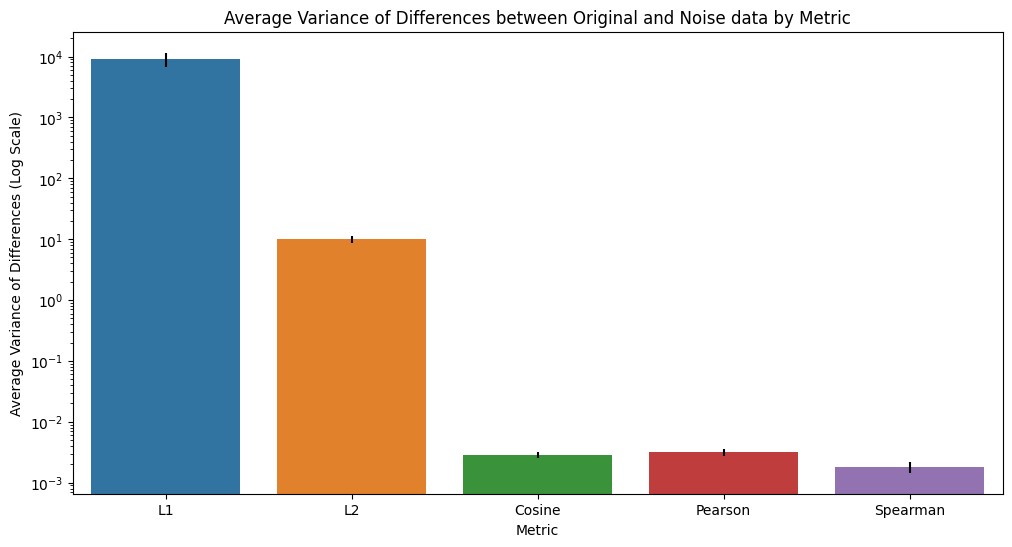

,dataset,Metric,Variance of differences,Metric Type,Robustness
0,TMSfacs_5K_t0.h5ad,L2,5.671968,Distance,Distance
1,TMSfacs_5K_t0.h5ad,L1,2911.789985,Distance,Distance
2,TMSfacs_5K_t0.h5ad,Pearson,0.002951,Similarity,Distance
3,TMSfacs_5K_t0.h5ad,Cosine,0.002754,Similarity,Distance
4,TMSfacs_5K_t0.h5ad,Spearman,0.002525,Similarity,Distance
...,...,...,...,...,...
80,MouseKidneyAtlas_5K_t0.h5ad,L2,4.941889,Distance,Distance
81,MouseKidneyAtlas_5K_t0.h5ad,L1,18065.496118,Distance,Distance
82,MouseKidneyAtlas_5K_t0.h5ad,Pearson,0.000871,Similarity,Distance
83,MouseKidneyAtlas_5K_t0.h5ad,Cosine,0.000961,Similarity,Distance


In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
file_path = 'variance_results.csv'
data = pd.read_csv(file_path)
data['Metric'] = data['Metric'].apply(lambda x : 'L2' if x == 'Euclidean' else x)


# Calculate average variance and standard error for each Metric Type
avg_variance = data.groupby('Metric')['Variance of differences'].agg(['mean', 'sem']).reset_index()

# Define the order of metrics
metric_order = ['L1', 'L2', 'Cosine', 'Pearson', 'Spearman']

# Reorder the DataFrame according to metric_order
avg_variance['Metric'] = pd.Categorical(avg_variance['Metric'], categories=metric_order, ordered=True)
avg_variance = avg_variance.sort_values('Metric')

# Bar plot with logarithmic scale and confidence intervals for average Variance of differences by Metric Type
plt.figure(figsize=(12, 6))
sns.barplot(x='Metric', y='mean', data=avg_variance, yerr=avg_variance['sem'], order = metric_order)
plt.yscale('log')
plt.title('Average Variance of Differences between Original and Noise data by Metric')
plt.xlabel('Metric')
plt.ylabel('Average Variance of Differences (Log Scale)')
plt.show()
data